# Pre-flight checks

Import common modules, ensure MatplotLib plots figures inline, and prepare a function to save the figures.

In [2]:
import numpy as np
import os

np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save associated data/images
PROJECT_ROOT_DIR = "."
KAGGLE_COMP_ID = "titanic"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", KAGGLE_COMP_ID)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

# Load the data

Downloaded from the kaggle server

In [3]:
import os
import pandas as pd

DATA_PATH = os.path.join("datasets", "titanic")
def load_titanic_data(titanic_data_path=DATA_PATH):
    csv_path = os.path.join(titanic_data_path, "train.csv")
    return pd.read_csv(csv_path)
os.path

<module 'ntpath' from 'C:\\Anaconda3\\envs\\mlenv1\\lib\\ntpath.py'>

In [4]:
titanic = load_titanic_data()
pd.show_versions()


INSTALLED VERSIONS
------------------
commit           : b5958ee1999e9aead1938c0bba2b674378807b3d
python           : 3.6.13.final.0
python-bits      : 64
OS               : Windows
OS-release       : 10
Version          : 10.0.19041
machine          : AMD64
processor        : Intel64 Family 6 Model 58 Stepping 9, GenuineIntel
byteorder        : little
LC_ALL           : None
LANG             : None
LOCALE           : None.None

pandas           : 1.1.5
numpy            : 1.19.2
pytz             : 2021.1
dateutil         : 2.8.1
pip              : 21.0.1
setuptools       : 52.0.0.post20210125
Cython           : 0.29.23
pytest           : None
hypothesis       : None
sphinx           : None
blosc            : None
feather          : None
xlsxwriter       : None
lxml.etree       : None
html5lib         : None
pymysql          : None
psycopg2         : None
jinja2           : 2.11.3
IPython          : 7.16.1
pandas_datareader: None
bs4              : None
bottleneck       : None
fsspec   

# Have a quick butcher's at the data

In [5]:
titanic.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [6]:
titanic.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


<font color=red size=4>NOTE: missing features |Age|Cabin|Embarked|</font><br>
<font color=red size=4>NOTE: non-numerical values |Name|Sex|Ticket|Cabin|Embarked|</font>

**{includes labels}**

In [7]:
titanic.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


<font color=red size=4>NOTE: varying ranges (esp. |FARE|)</font>

Saving figure attribute_histogram_plots


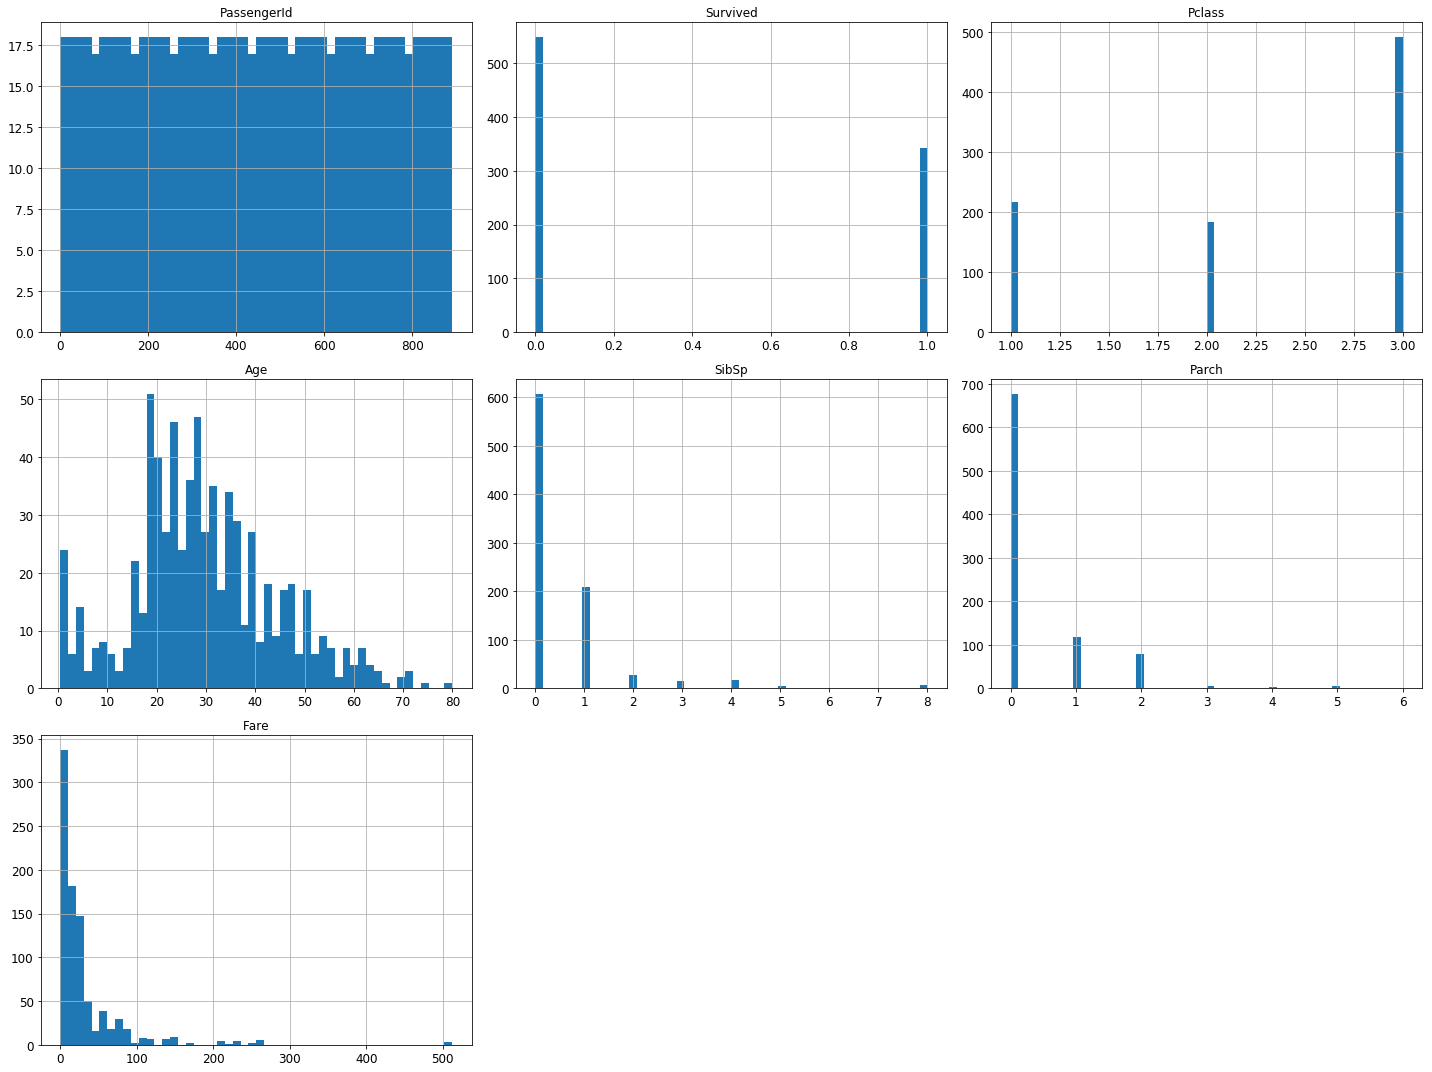

In [8]:
%matplotlib inline
import matplotlib.pyplot as plt
titanic.hist(bins=50, figsize=(20,15))
save_fig("attribute_histogram_plots")
plt.show()

**Try to turn Cabin into useable data, by binarizing variables according to null/not-null**

In [9]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline

class DataframeTransform():
    def __init__(self, func, column=None):
        self.function = func
        self.column = column

    def transform(self, df, **transform_params):
        return self.function(df, self.column)

    def fit(self, X, y=None, **fit_params):
        return self

In [10]:
def binarize(input_df, column):
    input_df[column] = input_df[column].notna()
    return input_df

def bool_to_int(input_df, column): 
    input_df[column] = input_df[column].map(lambda b: int(b))
    return input_df

df_pipeline = Pipeline([
    ("cabin_binarizer", DataframeTransform(binarize, "Cabin")),
    ("cabin_to_int", DataframeTransform(bool_to_int, "Cabin")),
])

processed_titanic = titanic.copy()
df_pipeline.fit_transform(processed_titanic)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,0,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,1,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,0,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,1,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,0,S
...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,0,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,1,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,0,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,1,C


In [11]:
processed_titanic.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare,Cabin
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208,0.228956
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429,0.420397
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400,0.000000
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200,0.000000
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000,0.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200,1.000000


<font color=red size=4>NOTE: long-tailed distributions |Age|Fare|Parch|SibSp|Cabin </font>

In [12]:
corr_matrix = processed_titanic.corr()

In [13]:
corr_matrix["Survived"].sort_values(ascending=False)

Survived       1.000000
Cabin          0.316912
Fare           0.257307
Parch          0.081629
PassengerId   -0.005007
SibSp         -0.035322
Age           -0.077221
Pclass        -0.338481
Name: Survived, dtype: float64

**Is Cabin a useful feature? How correlated is it with Pclass?**

In [14]:
corr_matrix["Pclass"].sort_values(ascending=False)

Pclass         1.000000
SibSp          0.083081
Parch          0.018443
PassengerId   -0.035144
Survived      -0.338481
Age           -0.369226
Fare          -0.549500
Cabin         -0.725541
Name: Pclass, dtype: float64

Fare and Cabin highly correlated with Pclass. <br>
<font color=green size=4> ※ May be helpful to combine Pclass&Cabin&Fare somehow </font>

Saving figure scatter_matrix_plot


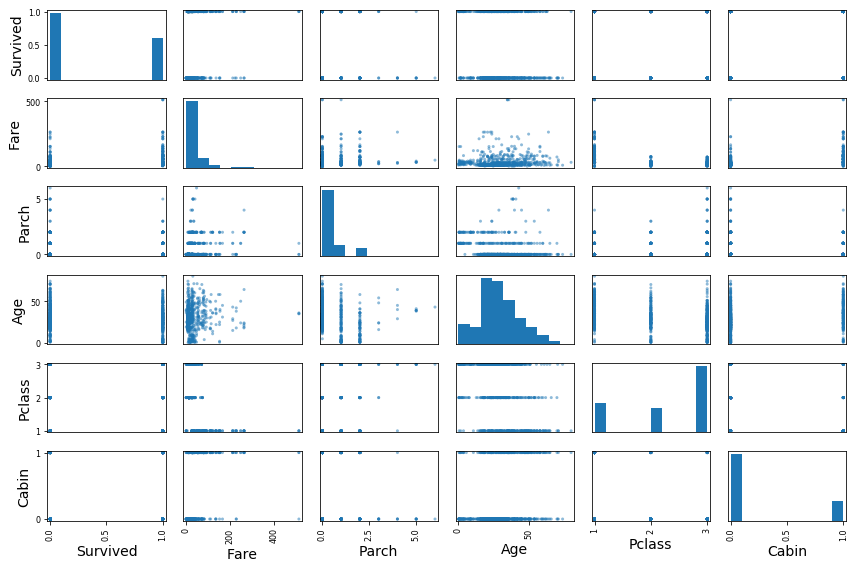

In [15]:
from pandas.plotting import scatter_matrix

attributes = ["Survived", "Fare", "Parch", "Age", "Pclass", "Cabin"]
scatter_matrix(processed_titanic[attributes], figsize=(12, 8))
save_fig("scatter_matrix_plot")

Saving figure fare_vs_survived


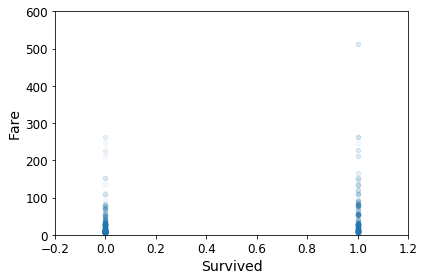

In [16]:
processed_titanic.plot(kind="scatter", x="Survived", y="Fare", alpha=0.05)
plt.axis([-0.2, 1.2, 0, 600])
save_fig("fare_vs_survived")

Saving figure age_vs_survived


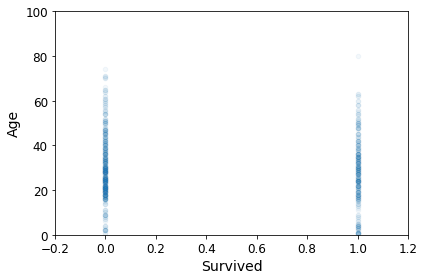

In [17]:
processed_titanic.plot(kind="scatter", x="Survived", y="Age", alpha=0.05)
plt.axis([-0.2, 1.2, 0, 100])
save_fig("age_vs_survived")

Saving figure cabin_vs_pclass


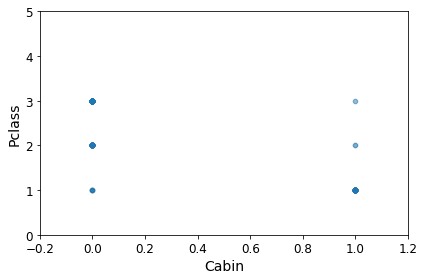

In [18]:
processed_titanic.plot(kind="scatter", x="Cabin", y="Pclass", alpha=0.05)
plt.axis([-0.2, 1.2, 0, 5])
save_fig("cabin_vs_pclass")

# Prepare the data for ML algorithms

In [19]:
titanic_features = titanic.drop("Survived", axis=1)
titanic_labels = titanic["Survived"].copy()

## Process df
<font color=blue size=4>ACTION: drop |Name| because the name can't possibly be directly relevant. (Though the name might be an indication of class or other potentially relevant features, so there may be some value in processing this feature later).</font>
<br><br>
<font color=blue size=4>ACTION: drop |Ticket| because any relevant data from this should be contained in other features, such as Pclass and fare.</font>
<br><br>
<font color=blue size=4>ACTION: binarize |Cabin| (Null/NotNull), as the simplest way to capture any patterns. </font>
<br><br>
<font color=green size=3>NOTE: could try categorizing |Cabin| later, based on first letter or range of following numbers, but this would require some research into the Titanic itself to properly understand how to process </font>

In [20]:
drop_features = ["Name", "Ticket"]

def features_drop(df, column=None):
    return df.drop(drop_features, axis=1)

df_pipeline = Pipeline([
    ("prune_features",DataframeTransform(features_drop)),
    ("cabin_binarizer", DataframeTransform(binarize, "Cabin")),
    ("cabin_to_int", DataframeTransform(bool_to_int, "Cabin")),
])

titanic_features_preprocessed = df_pipeline.fit_transform(titanic_features)
titanic_features_preprocessed.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Pclass       891 non-null    int64  
 2   Sex          891 non-null    object 
 3   Age          714 non-null    float64
 4   SibSp        891 non-null    int64  
 5   Parch        891 non-null    int64  
 6   Fare         891 non-null    float64
 7   Cabin        891 non-null    int64  
 8   Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(2)
memory usage: 62.8+ KB


## Transformation Pipelines 

### Numerical values:
-  remove attrbs
-  impute median
-  scale values
   
### Categorical values:
-  impute most_frequent
-  OneHotEncoding


In [21]:
titanic_features_preprocessed.values

array([[1, 3, 'male', ..., 7.25, 0, 'S'],
       [2, 1, 'female', ..., 71.2833, 1, 'C'],
       [3, 3, 'female', ..., 7.925, 0, 'S'],
       ...,
       [889, 3, 'female', ..., 23.45, 0, 'S'],
       [890, 1, 'male', ..., 30.0, 1, 'C'],
       [891, 3, 'male', ..., 7.75, 0, 'Q']], dtype=object)

In [22]:
titanic_features_preprocessed.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Pclass       891 non-null    int64  
 2   Sex          891 non-null    object 
 3   Age          714 non-null    float64
 4   SibSp        891 non-null    int64  
 5   Parch        891 non-null    int64  
 6   Fare         891 non-null    float64
 7   Cabin        891 non-null    int64  
 8   Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(2)
memory usage: 62.8+ KB


In [23]:
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

num_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("stdScaler", StandardScaler()),
])

In [24]:
most_common_embarked = titanic_features_preprocessed["Embarked"].value_counts().idxmax()
most_common_embarked

'S'

In [25]:
titanic_features_preprocessed["Embarked"].fillna(most_common_embarked, inplace=True)

In [26]:
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import OneHotEncoder


cat_pipeline = Pipeline([
    ("encode_ordinal", OrdinalEncoder()),
    ("imputer", SimpleImputer(strategy="median")),
    ("one_hot_encoder", OneHotEncoder()),
])

In [27]:
titanic_features_preprocessed.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Pclass       891 non-null    int64  
 2   Sex          891 non-null    object 
 3   Age          714 non-null    float64
 4   SibSp        891 non-null    int64  
 5   Parch        891 non-null    int64  
 6   Fare         891 non-null    float64
 7   Cabin        891 non-null    int64  
 8   Embarked     891 non-null    object 
dtypes: float64(2), int64(5), object(2)
memory usage: 62.8+ KB


In [28]:
cat_features = ["Sex", "Embarked", "Pclass"]
num_features = list(titanic_features_preprocessed.select_dtypes(include=[np.number]))
num_features.remove("Pclass")
num_features

['PassengerId', 'Age', 'SibSp', 'Parch', 'Fare', 'Cabin']

In [29]:
from sklearn.compose import ColumnTransformer

full_pipeline = ColumnTransformer([
    ("num", num_pipeline, num_features),
    ("cat", cat_pipeline, cat_features),
])

titanic_prepared = full_pipeline.fit_transform(titanic_features_preprocessed)
titanic_prepared

array([[-1.73010796, -0.56573646,  0.43279337, ...,  0.        ,
         0.        ,  1.        ],
       [-1.72622007,  0.66386103,  0.43279337, ...,  1.        ,
         0.        ,  0.        ],
       [-1.72233219, -0.25833709, -0.4745452 , ...,  0.        ,
         0.        ,  1.        ],
       ...,
       [ 1.72233219, -0.1046374 ,  0.43279337, ...,  0.        ,
         0.        ,  1.        ],
       [ 1.72622007, -0.25833709, -0.4745452 , ...,  1.        ,
         0.        ,  0.        ],
       [ 1.73010796,  0.20276197, -0.4745452 , ...,  0.        ,
         0.        ,  1.        ]])

In [30]:
titanic_prepared.shape

(891, 14)

# Select and train a model 

### Evaluation and display functions 

In [31]:
# evaluate using cross validation
from sklearn.model_selection import cross_val_score
from sklearn import metrics

def display_scores(scores):
    print("Scores:", scores)
    print("Mean:", scores.mean())
    print("Standard deviation:", scores.std())
    
def display_metrics(model):
    predictions = pd.DataFrame(model.predict(titanic_prepared))
    print("Accuracy:", metrics.accuracy_score(titanic_labels, predictions))
    print("")
    print("Confusion matrix:")
    print(metrics.confusion_matrix(titanic_labels, predictions))
    print("")
    print("Classification report:")
    print(metrics.classification_report(titanic_labels, predictions))

def display_cv_scores(model):
    scores = cross_val_score(model, titanic_prepared, titanic_labels,scoring="accuracy", cv=10)
    display_scores(scores)

## Logistic Regression

### Assumptions:
-  binary labels YES
-  no outliers ~YES (may be violated by |Fare|Parch|)
-  no multicollinearity among features (below 0.90 should be fine, so we're ok on this) YES

### Conclusion: 
Probably quite a good model.

Confusion matrix:<br><br>
TN FP<br>
FN TP<br>

In [32]:
from sklearn.linear_model import LogisticRegression

log_reg = LogisticRegression(solver="saga", max_iter=1000, random_state=42)
log_reg.fit(titanic_prepared, titanic_labels)

LogisticRegression(max_iter=1000, random_state=42, solver='saga')

In [33]:
log_reg.score(titanic_prepared, titanic_labels)

0.8114478114478114

In [34]:
display_cv_scores(log_reg)

Scores: [0.83333333 0.82022472 0.76404494 0.82022472 0.82022472 0.76404494
 0.78651685 0.78651685 0.82022472 0.83146067]
Mean: 0.804681647940075
Standard deviation: 0.025430270332036584


In [35]:
display_metrics(log_reg)

Accuracy: 0.8114478114478114

Confusion matrix:
[[476  73]
 [ 95 247]]

Classification report:
              precision    recall  f1-score   support

           0       0.83      0.87      0.85       549
           1       0.77      0.72      0.75       342

    accuracy                           0.81       891
   macro avg       0.80      0.79      0.80       891
weighted avg       0.81      0.81      0.81       891



## Naive bayes (gaussian)

### Assumptions

- The features are independent from one another

In [36]:
from sklearn.naive_bayes import GaussianNB

nb = GaussianNB()
nb.fit(titanic_prepared, titanic_labels)

GaussianNB()

In [37]:
nb.score(titanic_prepared, titanic_labels)

0.7755331088664422

In [38]:
display_cv_scores(nb)

Scores: [0.75555556 0.73033708 0.76404494 0.73033708 0.79775281 0.74157303
 0.79775281 0.82022472 0.7752809  0.79775281]
Mean: 0.7710611735330837
Standard deviation: 0.030080386252688208


In [39]:
display_metrics(nb)

Accuracy: 0.7755331088664422

Confusion matrix:
[[420 129]
 [ 71 271]]

Classification report:
              precision    recall  f1-score   support

           0       0.86      0.77      0.81       549
           1       0.68      0.79      0.73       342

    accuracy                           0.78       891
   macro avg       0.77      0.78      0.77       891
weighted avg       0.79      0.78      0.78       891



## Decision Tree

### Assumptions

-  The data is not multicollinear. If the data contains collinearities, the decision tree will choose the best, greedily.
-  They are not smooth, so can have problems with overfitting and prediction from unusual feature vectors, in particular.
-  Assumed interactions between all features can make this inefficient, and ineffective with smaller amounts of loosely correlated data.

In [40]:
from sklearn import tree

In [41]:
tree_model = tree.DecisionTreeClassifier(max_depth=3)
tree_model_fit = tree_model.fit(titanic_prepared, titanic_labels)
tree_model_fit

DecisionTreeClassifier(max_depth=3)

In [42]:
tree_model_fit.score(titanic_prepared, titanic_labels)

0.8237934904601572

In [43]:
display_cv_scores(tree_model)

Scores: [0.82222222 0.83146067 0.76404494 0.85393258 0.82022472 0.79775281
 0.78651685 0.78651685 0.85393258 0.83146067]
Mean: 0.8148064918851435
Standard deviation: 0.02858136826801664


In [44]:
from pydotplus import graph_from_dot_data

dot_data = tree.export_graphviz(tree_model, out_file=None,  
                     feature_names=titanic_features_preprocessed.columns.tolist().extend(["dummy", "dummy", "dummy"]),
                     class_names=['生', '死'],
                     filled=True, rounded=True,  
                     special_characters=True)  
graph = graph_from_dot_data(dot_data)
save_fig("decision_tree_graph")

Saving figure decision_tree_graph


<Figure size 432x288 with 0 Axes>

In [45]:
display_metrics(tree_model)

Accuracy: 0.8237934904601572

Confusion matrix:
[[488  61]
 [ 96 246]]

Classification report:
              precision    recall  f1-score   support

           0       0.84      0.89      0.86       549
           1       0.80      0.72      0.76       342

    accuracy                           0.82       891
   macro avg       0.82      0.80      0.81       891
weighted avg       0.82      0.82      0.82       891



## RandomForest

In [46]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(random_state=42, n_estimators=100, max_depth=5, bootstrap=False)
rf_model = rf.fit(titanic_prepared, titanic_labels)
rf_model

RandomForestClassifier(bootstrap=False, max_depth=5, random_state=42)

In [47]:
rf_model.score(titanic_prepared, titanic_labels)

0.8585858585858586

In [48]:
display_cv_scores(rf)

Scores: [0.83333333 0.86516854 0.76404494 0.86516854 0.85393258 0.78651685
 0.78651685 0.76404494 0.85393258 0.87640449]
Mean: 0.8249063670411985
Standard deviation: 0.042433399102880215


In [49]:
display_metrics(rf)

Accuracy: 0.8585858585858586

Confusion matrix:
[[511  38]
 [ 88 254]]

Classification report:
              precision    recall  f1-score   support

           0       0.85      0.93      0.89       549
           1       0.87      0.74      0.80       342

    accuracy                           0.86       891
   macro avg       0.86      0.84      0.85       891
weighted avg       0.86      0.86      0.86       891



## Support Vector Model

In [50]:
from sklearn.svm import SVC

### kernel=linear

In [51]:
svc_linear = SVC(kernel="linear")
svc_linear_model = svc_linear.fit(titanic_prepared, titanic_labels)
svc_linear_model

SVC(kernel='linear')

In [52]:
svc_linear_model.score(titanic_prepared, titanic_labels)

0.7867564534231201

In [53]:
display_cv_scores(svc_linear)

Scores: [0.81111111 0.78651685 0.76404494 0.84269663 0.79775281 0.7752809
 0.76404494 0.74157303 0.80898876 0.76404494]
Mean: 0.785605493133583
Standard deviation: 0.02836393163253107


In [54]:
display_metrics(svc_linear)

Accuracy: 0.7867564534231201

Confusion matrix:
[[468  81]
 [109 233]]

Classification report:
              precision    recall  f1-score   support

           0       0.81      0.85      0.83       549
           1       0.74      0.68      0.71       342

    accuracy                           0.79       891
   macro avg       0.78      0.77      0.77       891
weighted avg       0.78      0.79      0.78       891



### kernel=polynomial

In [55]:
svc_poly = SVC(kernel="poly")
svc_poly_model = svc_poly.fit(titanic_prepared, titanic_labels)
svc_poly_model

SVC(kernel='poly')

In [56]:
svc_poly_model.score(titanic_prepared, titanic_labels)

0.8473625140291807

In [57]:
display_cv_scores(svc_poly)

Scores: [0.77777778 0.80898876 0.74157303 0.83146067 0.84269663 0.78651685
 0.82022472 0.76404494 0.88764045 0.85393258]
Mean: 0.8114856429463172
Standard deviation: 0.042373440071103954


In [58]:
display_metrics(svc_poly)

Accuracy: 0.8473625140291807

Confusion matrix:
[[497  52]
 [ 84 258]]

Classification report:
              precision    recall  f1-score   support

           0       0.86      0.91      0.88       549
           1       0.83      0.75      0.79       342

    accuracy                           0.85       891
   macro avg       0.84      0.83      0.84       891
weighted avg       0.85      0.85      0.85       891



### kernel=rbf

In [59]:
svc_rbf = SVC(kernel="rbf")
svc_rbf_model = svc_rbf.fit(titanic_prepared, titanic_labels)
svc_rbf_model

SVC()

In [60]:
svc_rbf_model.score(titanic_prepared, titanic_labels)

0.8417508417508418

In [61]:
display_cv_scores(svc_rbf)

Scores: [0.8        0.86516854 0.75280899 0.87640449 0.80898876 0.78651685
 0.83146067 0.79775281 0.86516854 0.85393258]
Mean: 0.823820224719101
Standard deviation: 0.03879513490258261


In [62]:
display_metrics(svc_rbf)

Accuracy: 0.8417508417508418

Confusion matrix:
[[495  54]
 [ 87 255]]

Classification report:
              precision    recall  f1-score   support

           0       0.85      0.90      0.88       549
           1       0.83      0.75      0.78       342

    accuracy                           0.84       891
   macro avg       0.84      0.82      0.83       891
weighted avg       0.84      0.84      0.84       891



### kernel=sigmoid

In [63]:
svc_sigmoid = SVC(kernel="sigmoid")
svc_sigmoid_model = svc_sigmoid.fit(titanic_prepared, titanic_labels)
svc_sigmoid_model

SVC(kernel='sigmoid')

In [64]:
svc_sigmoid_model.score(titanic_prepared, titanic_labels)

0.6778900112233446

In [65]:
display_cv_scores(svc_sigmoid)

Scores: [0.71111111 0.64044944 0.73033708 0.6741573  0.71910112 0.66292135
 0.6741573  0.68539326 0.66292135 0.62921348]
Mean: 0.6789762796504369
Standard deviation: 0.03137575484089663


In [66]:
display_metrics(svc_sigmoid)

Accuracy: 0.6778900112233446

Confusion matrix:
[[407 142]
 [145 197]]

Classification report:
              precision    recall  f1-score   support

           0       0.74      0.74      0.74       549
           1       0.58      0.58      0.58       342

    accuracy                           0.68       891
   macro avg       0.66      0.66      0.66       891
weighted avg       0.68      0.68      0.68       891



# Fine-tune best model(s)

## RandomForest

In [67]:
from sklearn.model_selection import RandomizedSearchCV 

rf_base = RandomForestClassifier(random_state=42, bootstrap=False)
rf_grid = {
#     'bootstrap': [True, False],
               'max_depth': [3, 5, 10, 20, 30, 40, None],
#                'max_features': ['auto', 'sqrt'],
               'min_samples_leaf': [1, 2, 4],
               'min_samples_split': [5, 10, 15],
               'n_estimators': [50, 60, 70, 80, 100]}
rf_search = RandomizedSearchCV(
    estimator=rf_base, 
    param_distributions = rf_grid, 
    n_iter=200, cv=10, verbose=2, random_state=42, n_jobs=-1)

rf_search.fit(titanic_prepared, titanic_labels)

Fitting 10 folds for each of 200 candidates, totalling 2000 fits


RandomizedSearchCV(cv=10,
                   estimator=RandomForestClassifier(bootstrap=False,
                                                    random_state=42),
                   n_iter=200, n_jobs=-1,
                   param_distributions={'max_depth': [3, 5, 10, 20, 30, 40,
                                                      None],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [5, 10, 15],
                                        'n_estimators': [50, 60, 70, 80, 100]},
                   random_state=42, verbose=2)

In [68]:
def print_mean_score_params(cv_results):
    for mean_score, params in zip(cv_results["mean_test_score"], cv_results["params"]):
        print(mean_score, params)

In [69]:
rf_cv_results = rf_search.cv_results_
print_mean_score_params(rf_cv_results)

0.8249313358302123 {'n_estimators': 60, 'min_samples_split': 15, 'min_samples_leaf': 2, 'max_depth': 30}
0.8125593008739077 {'n_estimators': 80, 'min_samples_split': 5, 'min_samples_leaf': 4, 'max_depth': 3}
0.8249313358302123 {'n_estimators': 80, 'min_samples_split': 15, 'min_samples_leaf': 2, 'max_depth': 20}
0.8249063670411985 {'n_estimators': 80, 'min_samples_split': 5, 'min_samples_leaf': 4, 'max_depth': 5}
0.8260424469413234 {'n_estimators': 80, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_depth': 10}
0.8238451935081148 {'n_estimators': 100, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_depth': 40}
0.8193008739076154 {'n_estimators': 50, 'min_samples_split': 15, 'min_samples_leaf': 2, 'max_depth': 3}
0.8092009987515606 {'n_estimators': 100, 'min_samples_split': 10, 'min_samples_leaf': 1, 'max_depth': 3}
0.8294007490636703 {'n_estimators': 80, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_depth': 5}
0.8249063670411985 {'n_estimators': 70, 'min_samples_split': 10

In [70]:
best_rf = rf_search.best_estimator_
best_rf

RandomForestClassifier(bootstrap=False, min_samples_split=15, n_estimators=50,
                       random_state=42)

In [71]:
best_rf.score(titanic_prepared, titanic_labels)

0.9304152637485971

In [72]:
display_cv_scores(best_rf)

Scores: [0.82222222 0.85393258 0.74157303 0.80898876 0.91011236 0.84269663
 0.82022472 0.80898876 0.88764045 0.83146067]
Mean: 0.8327840199750313
Standard deviation: 0.04388317767476118


**NB score ~= cv_score + 10 : probably overfitting**

In [73]:
display_metrics(best_rf)

Accuracy: 0.9304152637485971

Confusion matrix:
[[534  15]
 [ 47 295]]

Classification report:
              precision    recall  f1-score   support

           0       0.92      0.97      0.95       549
           1       0.95      0.86      0.90       342

    accuracy                           0.93       891
   macro avg       0.94      0.92      0.93       891
weighted avg       0.93      0.93      0.93       891



## SVM kernel=rbf

In [74]:
from sklearn.model_selection import GridSearchCV

def perform_grid_search(_estimator, _param_grid):
    search = GridSearchCV(
        estimator=_estimator,
        param_grid=_param_grid, 
        cv=10, verbose=3, n_jobs=-1)
    search.fit(titanic_prepared, titanic_labels)
    return search

svc_rbf_base = SVC(kernel="rbf")
svc_rbf_grid = {
    'gamma': [0.1, 1, 10],
    'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
}

svc_rbf_search = perform_grid_search(svc_rbf_base, svc_rbf_grid)

Fitting 10 folds for each of 21 candidates, totalling 210 fits


In [75]:
svc_rbf_cv_results = svc_rbf_search.cv_results_
print_mean_score_params(svc_rbf_cv_results)

0.616167290886392 {'C': 0.001, 'gamma': 0.1}
0.616167290886392 {'C': 0.001, 'gamma': 1}
0.616167290886392 {'C': 0.001, 'gamma': 10}
0.616167290886392 {'C': 0.01, 'gamma': 0.1}
0.616167290886392 {'C': 0.01, 'gamma': 1}
0.616167290886392 {'C': 0.01, 'gamma': 10}
0.8035830212234707 {'C': 0.1, 'gamma': 0.1}
0.6195380774032458 {'C': 0.1, 'gamma': 1}
0.616167290886392 {'C': 0.1, 'gamma': 10}
0.8204494382022471 {'C': 1, 'gamma': 0.1}
0.7845942571785269 {'C': 1, 'gamma': 1}
0.6486891385767791 {'C': 1, 'gamma': 10}
0.809238451935081 {'C': 10, 'gamma': 0.1}
0.7610486891385768 {'C': 10, 'gamma': 1}
0.6172284644194755 {'C': 10, 'gamma': 10}
0.7711111111111111 {'C': 100, 'gamma': 0.1}
0.7363171036204745 {'C': 100, 'gamma': 1}
0.6161298377028714 {'C': 100, 'gamma': 10}
0.7587390761548065 {'C': 1000, 'gamma': 0.1}
0.682434456928839 {'C': 1000, 'gamma': 1}
0.6183770287141075 {'C': 1000, 'gamma': 10}


In [76]:
best_svc_rbf = svc_rbf_search.best_estimator_
best_svc_rbf

SVC(C=1, gamma=0.1)

#### Iter: 2 centre: {'C': 1, 'gamma': 0.1}

In [77]:
svc_rbf_grid_2 = {
    'gamma': [0.05, 0.1, 0.5],
    'C': [0.1, 0.5, 1, 5, 10],
}

svc_rbf_search = perform_grid_search(svc_rbf_base, svc_rbf_grid_2)
svc_rbf_search

Fitting 10 folds for each of 15 candidates, totalling 150 fits


GridSearchCV(cv=10, estimator=SVC(), n_jobs=-1,
             param_grid={'C': [0.1, 0.5, 1, 5, 10], 'gamma': [0.05, 0.1, 0.5]},
             verbose=3)

In [78]:
svc_rbf_cv_results = svc_rbf_search.cv_results_
print_mean_score_params(svc_rbf_cv_results)

0.7979650436953808 {'C': 0.1, 'gamma': 0.05}
0.8035830212234707 {'C': 0.1, 'gamma': 0.1}
0.7407365792759051 {'C': 0.1, 'gamma': 0.5}
0.8125717852684146 {'C': 0.5, 'gamma': 0.05}
0.8159425717852684 {'C': 0.5, 'gamma': 0.1}
0.8013732833957553 {'C': 0.5, 'gamma': 0.5}
0.8204369538077403 {'C': 1, 'gamma': 0.05}
0.8204494382022471 {'C': 1, 'gamma': 0.1}
0.789063670411985 {'C': 1, 'gamma': 0.5}
0.8204494382022471 {'C': 5, 'gamma': 0.05}
0.8092384519350813 {'C': 5, 'gamma': 0.1}
0.7756304619225968 {'C': 5, 'gamma': 0.5}
0.8137203495630463 {'C': 10, 'gamma': 0.05}
0.809238451935081 {'C': 10, 'gamma': 0.1}
0.7755805243445691 {'C': 10, 'gamma': 0.5}


In [79]:
best_svc_rbf = svc_rbf_search.best_estimator_
best_svc_rbf

SVC(C=1, gamma=0.1)

#### No change, so try tighter distribution around  {'C': 1, 'gamma': 0.1}

In [80]:
svc_rbf_grid_3 = {
    'gamma': [0.08, 0.09, 0.1, 0.11, 0.12],
    'C': [0.6, 0.7, 0.8, 0.9, 1, 1.1, 1.2, 1.3, 1.4],
}

svc_rbf_search = perform_grid_search(svc_rbf_base, svc_rbf_grid_3)
svc_rbf_search

Fitting 10 folds for each of 45 candidates, totalling 450 fits


GridSearchCV(cv=10, estimator=SVC(), n_jobs=-1,
             param_grid={'C': [0.6, 0.7, 0.8, 0.9, 1, 1.1, 1.2, 1.3, 1.4],
                         'gamma': [0.08, 0.09, 0.1, 0.11, 0.12]},
             verbose=3)

In [81]:
svc_rbf_cv_results = svc_rbf_search.cv_results_
print_mean_score_params(svc_rbf_cv_results)

0.8193133583021224 {'C': 0.6, 'gamma': 0.08}
0.8181897627965045 {'C': 0.6, 'gamma': 0.09}
0.8193133583021224 {'C': 0.6, 'gamma': 0.1}
0.8204369538077403 {'C': 0.6, 'gamma': 0.11}
0.8193133583021224 {'C': 0.6, 'gamma': 0.12}
0.8215605493133582 {'C': 0.7, 'gamma': 0.08}
0.8193133583021224 {'C': 0.7, 'gamma': 0.09}
0.8215605493133582 {'C': 0.7, 'gamma': 0.1}
0.8226841448189763 {'C': 0.7, 'gamma': 0.11}
0.8215605493133582 {'C': 0.7, 'gamma': 0.12}
0.8215605493133582 {'C': 0.8, 'gamma': 0.08}
0.8204369538077403 {'C': 0.8, 'gamma': 0.09}
0.8226841448189763 {'C': 0.8, 'gamma': 0.1}
0.8215605493133582 {'C': 0.8, 'gamma': 0.11}
0.8193258426966292 {'C': 0.8, 'gamma': 0.12}
0.8215605493133582 {'C': 0.9, 'gamma': 0.08}
0.8215605493133582 {'C': 0.9, 'gamma': 0.09}
0.8182022471910113 {'C': 0.9, 'gamma': 0.1}
0.8215730337078652 {'C': 0.9, 'gamma': 0.11}
0.8204494382022471 {'C': 0.9, 'gamma': 0.12}
0.8226841448189761 {'C': 1, 'gamma': 0.08}
0.8204494382022471 {'C': 1, 'gamma': 0.09}
0.8204494382022471

In [82]:
best_svc_rbf = svc_rbf_search.best_estimator_
best_svc_rbf

SVC(C=1.1, gamma=0.11)

#### 2 best: {'C': 1.1, 'gamma': 0.11}, {'C': 1.4, 'gamma': 0.09}

In [83]:
svc_rbf_grid_4 = {
    'gamma': [0.08, 0.085, 0.09, 0.095, 0.1, 0.105, 0.11, 0.115, 0.12, 0.125],
    'C': [1.1, 1.15, 1.2, 1.25, 1.3, 1.35, 1.4, 1.45, 1.5, 1.55, 1.6, 1.65, 1.7, 1.75],
}

svc_rbf_search = perform_grid_search(svc_rbf_base, svc_rbf_grid_4)
svc_rbf_search

Fitting 10 folds for each of 140 candidates, totalling 1400 fits


GridSearchCV(cv=10, estimator=SVC(), n_jobs=-1,
             param_grid={'C': [1.1, 1.15, 1.2, 1.25, 1.3, 1.35, 1.4, 1.45, 1.5,
                               1.55, 1.6, 1.65, 1.7, 1.75],
                         'gamma': [0.08, 0.085, 0.09, 0.095, 0.1, 0.105, 0.11,
                                   0.115, 0.12, 0.125]},
             verbose=3)

In [84]:
svc_rbf_cv_results = svc_rbf_search.cv_results_
print_mean_score_params(svc_rbf_cv_results)

0.8215730337078652 {'C': 1.1, 'gamma': 0.08}
0.8204494382022471 {'C': 1.1, 'gamma': 0.085}
0.8215730337078652 {'C': 1.1, 'gamma': 0.09}
0.8215730337078652 {'C': 1.1, 'gamma': 0.095}
0.823820224719101 {'C': 1.1, 'gamma': 0.1}
0.823820224719101 {'C': 1.1, 'gamma': 0.105}
0.8249438202247191 {'C': 1.1, 'gamma': 0.11}
0.823820224719101 {'C': 1.1, 'gamma': 0.115}
0.8238202247191012 {'C': 1.1, 'gamma': 0.12}
0.8226966292134831 {'C': 1.1, 'gamma': 0.125}
0.8215730337078652 {'C': 1.15, 'gamma': 0.08}
0.8215730337078652 {'C': 1.15, 'gamma': 0.085}
0.8215730337078652 {'C': 1.15, 'gamma': 0.09}
0.8215730337078652 {'C': 1.15, 'gamma': 0.095}
0.8226966292134831 {'C': 1.15, 'gamma': 0.1}
0.8226966292134831 {'C': 1.15, 'gamma': 0.105}
0.823820224719101 {'C': 1.15, 'gamma': 0.11}
0.8215730337078652 {'C': 1.15, 'gamma': 0.115}
0.8226966292134831 {'C': 1.15, 'gamma': 0.12}
0.8226966292134831 {'C': 1.15, 'gamma': 0.125}
0.8215730337078652 {'C': 1.2, 'gamma': 0.08}
0.8215730337078652 {'C': 1.2, 'gamma': 0.

In [85]:
best_svc_rbf = svc_rbf_search.best_estimator_
best_svc_rbf

SVC(C=1.65, gamma=0.08)

In [86]:
best_svc_rbf.score(titanic_prepared, titanic_labels)

0.8372615039281706

In [87]:
display_cv_scores(best_svc_rbf)

Scores: [0.8        0.86516854 0.75280899 0.87640449 0.83146067 0.79775281
 0.83146067 0.79775281 0.86516854 0.84269663]
Mean: 0.826067415730337
Standard deviation: 0.03684571023651162


**score much lower than RandomForest, but cv_score almost the same. Should generalize fairly well, or perhaps slightly underfitting**

In [88]:
display_metrics(best_svc_rbf)

Accuracy: 0.8372615039281706

Confusion matrix:
[[498  51]
 [ 94 248]]

Classification report:
              precision    recall  f1-score   support

           0       0.84      0.91      0.87       549
           1       0.83      0.73      0.77       342

    accuracy                           0.84       891
   macro avg       0.84      0.82      0.82       891
weighted avg       0.84      0.84      0.83       891



## LogisticRegression

In [89]:
log_reg_base = log_reg
log_reg_grid_0 = {
    'penalty': ["none", "l1", "l2", "elasticnet"],
    'C': [0.1, 1.0, 10],
    'class_weight': ["balanced", None],  
}
log_reg_search = perform_grid_search(log_reg_base, log_reg_grid_0)
log_reg_search

Fitting 10 folds for each of 24 candidates, totalling 240 fits


C:\Anaconda3\envs\mlenv1\lib\site-packages\sklearn\model_selection\_search.py:921: UserWarning: One or more of the test scores are non-finite: [0.78563046 0.7878402  0.79008739        nan 0.80468165 0.79573034
 0.80247191        nan 0.78563046 0.78561798 0.78563046        nan
 0.80468165 0.80580524 0.80468165        nan 0.78563046 0.78563046
 0.78563046        nan 0.80468165 0.80468165 0.80468165        nan]
  category=UserWarning


GridSearchCV(cv=10,
             estimator=LogisticRegression(max_iter=1000, random_state=42,
                                          solver='saga'),
             n_jobs=-1,
             param_grid={'C': [0.1, 1.0, 10],
                         'class_weight': ['balanced', None],
                         'penalty': ['none', 'l1', 'l2', 'elasticnet']},
             verbose=3)

In [90]:
log_reg_cv_results = log_reg_search.cv_results_
print_mean_score_params(log_reg_cv_results)

0.7856304619225967 {'C': 0.1, 'class_weight': 'balanced', 'penalty': 'none'}
0.787840199750312 {'C': 0.1, 'class_weight': 'balanced', 'penalty': 'l1'}
0.790087390761548 {'C': 0.1, 'class_weight': 'balanced', 'penalty': 'l2'}
nan {'C': 0.1, 'class_weight': 'balanced', 'penalty': 'elasticnet'}
0.804681647940075 {'C': 0.1, 'class_weight': None, 'penalty': 'none'}
0.7957303370786517 {'C': 0.1, 'class_weight': None, 'penalty': 'l1'}
0.8024719101123596 {'C': 0.1, 'class_weight': None, 'penalty': 'l2'}
nan {'C': 0.1, 'class_weight': None, 'penalty': 'elasticnet'}
0.7856304619225967 {'C': 1.0, 'class_weight': 'balanced', 'penalty': 'none'}
0.7856179775280899 {'C': 1.0, 'class_weight': 'balanced', 'penalty': 'l1'}
0.7856304619225967 {'C': 1.0, 'class_weight': 'balanced', 'penalty': 'l2'}
nan {'C': 1.0, 'class_weight': 'balanced', 'penalty': 'elasticnet'}
0.804681647940075 {'C': 1.0, 'class_weight': None, 'penalty': 'none'}
0.8058052434456929 {'C': 1.0, 'class_weight': None, 'penalty': 'l1'}
0.8

In [91]:
best_log_reg = log_reg_search.best_estimator_
best_log_reg

LogisticRegression(max_iter=1000, penalty='l1', random_state=42, solver='saga')

In [92]:
best_log_reg.score(titanic_prepared, titanic_labels)

0.8125701459034792

In [93]:
display_cv_scores(best_log_reg)

Scores: [0.83333333 0.82022472 0.76404494 0.83146067 0.80898876 0.76404494
 0.78651685 0.78651685 0.82022472 0.84269663]
Mean: 0.8058052434456929
Standard deviation: 0.027266972239553294


In [94]:
display_metrics(best_log_reg)

Accuracy: 0.8125701459034792

Confusion matrix:
[[476  73]
 [ 94 248]]

Classification report:
              precision    recall  f1-score   support

           0       0.84      0.87      0.85       549
           1       0.77      0.73      0.75       342

    accuracy                           0.81       891
   macro avg       0.80      0.80      0.80       891
weighted avg       0.81      0.81      0.81       891



#### C centred around 1.0

In [95]:
log_reg_grid_0 = {
    'penalty': ["none", "l1", "l2"],
    'C': [0.6, 0.7, 0.8, 0.9, 1.0, 1.1, 1.2, 1.3, 1.4, 1.5, 2.0],
    'class_weight': ["balanced", None],  
}
log_reg_search = perform_grid_search(log_reg_base, log_reg_grid_0)
log_reg_search

Fitting 10 folds for each of 66 candidates, totalling 660 fits


GridSearchCV(cv=10,
             estimator=LogisticRegression(max_iter=1000, random_state=42,
                                          solver='saga'),
             n_jobs=-1,
             param_grid={'C': [0.6, 0.7, 0.8, 0.9, 1.0, 1.1, 1.2, 1.3, 1.4, 1.5,
                               2.0],
                         'class_weight': ['balanced', None],
                         'penalty': ['none', 'l1', 'l2']},
             verbose=3)

In [96]:
best_log_reg = log_reg_search.best_estimator_
best_log_reg

LogisticRegression(C=0.9, max_iter=1000, penalty='l1', random_state=42,
                   solver='saga')

In [97]:
display_cv_scores(best_log_reg)

Scores: [0.83333333 0.82022472 0.76404494 0.83146067 0.79775281 0.76404494
 0.78651685 0.78651685 0.83146067 0.85393258]
Mean: 0.8069288389513108
Standard deviation: 0.029803534048061946


In [98]:
display_metrics(best_log_reg)

Accuracy: 0.8125701459034792

Confusion matrix:
[[476  73]
 [ 94 248]]

Classification report:
              precision    recall  f1-score   support

           0       0.84      0.87      0.85       549
           1       0.77      0.73      0.75       342

    accuracy                           0.81       891
   macro avg       0.80      0.80      0.80       891
weighted avg       0.81      0.81      0.81       891



#### All of my models are unbalanced in their mistakes, with FN > FP, other than NaiveBayes. NaiveBayes doesn't output very accurate confidence scores/probabilities, so let's build a LogisticRegressor with high negative precision, and then build an ensemble leveraging the differences in three models:
- RandomForest : very accurate, but probably high variance
- SVM(kernel=rbf) : close cv / training set scores. Might be slightly underfitting
- LogisticRegressor : More balanced than the others, and linear

In [99]:
from sklearn.ensemble import StackingClassifier

estimators = [
    ('rf', best_rf),
    ('svc_rbf', best_svc_rbf),
    ('log_reg', best_log_reg)
]
clf = StackingClassifier(
    estimators=estimators, final_estimator=SVC()
)
clf.fit(titanic_prepared, titanic_labels)

StackingClassifier(estimators=[('rf',
                                RandomForestClassifier(bootstrap=False,
                                                       min_samples_split=15,
                                                       n_estimators=50,
                                                       random_state=42)),
                               ('svc_rbf', SVC(C=1.65, gamma=0.08)),
                               ('log_reg',
                                LogisticRegression(C=0.9, max_iter=1000,
                                                   penalty='l1',
                                                   random_state=42,
                                                   solver='saga'))],
                   final_estimator=SVC())

In [100]:
clf.score(titanic_prepared, titanic_labels)

0.8428731762065096

In [101]:
display_cv_scores(clf)

Scores: [0.8        0.87640449 0.75280899 0.86516854 0.83146067 0.7752809
 0.84269663 0.79775281 0.87640449 0.85393258]
Mean: 0.8271910112359551
Standard deviation: 0.04134403983765025


In [102]:
display_metrics(clf)

Accuracy: 0.8428731762065096

Confusion matrix:
[[497  52]
 [ 88 254]]

Classification report:
              precision    recall  f1-score   support

           0       0.85      0.91      0.88       549
           1       0.83      0.74      0.78       342

    accuracy                           0.84       891
   macro avg       0.84      0.82      0.83       891
weighted avg       0.84      0.84      0.84       891



# Predictions

In [103]:
def load_titanic_test_data(titanic_data_path=DATA_PATH):
    csv_path = os.path.join(titanic_data_path, "test.csv")
    return pd.read_csv(csv_path)
os.path

<module 'ntpath' from 'C:\\Anaconda3\\envs\\mlenv1\\lib\\ntpath.py'>

In [104]:
test = load_titanic_test_data()
test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [105]:
test.describe()

,PassengerId,Pclass,Age,SibSp,Parch,Fare
count,418.000000,418.000000,332.000000,418.000000,418.000000,417.000000
mean,1100.500000,2.265550,30.272590,0.447368,0.392344,35.627188
std,120.810458,0.841838,14.181209,0.896760,0.981429,55.907576
min,892.000000,1.000000,0.170000,0.000000,0.000000,0.000000
25%,996.250000,1.000000,21.000000,0.000000,0.000000,7.895800
50%,1100.500000,3.000000,27.000000,0.000000,0.000000,14.454200
75%,1204.750000,3.000000,39.000000,1.000000,0.000000,31.500000
max,1309.000000,3.000000,76.000000,8.000000,9.000000,512.329200


In [106]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Pclass       418 non-null    int64  
 2   Name         418 non-null    object 
 3   Sex          418 non-null    object 
 4   Age          332 non-null    float64
 5   SibSp        418 non-null    int64  
 6   Parch        418 non-null    int64  
 7   Ticket       418 non-null    object 
 8   Fare         417 non-null    float64
 9   Cabin        91 non-null     object 
 10  Embarked     418 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 36.0+ KB


In [107]:
titanic_features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Pclass       891 non-null    int64  
 2   Name         891 non-null    object 
 3   Sex          891 non-null    object 
 4   Age          714 non-null    float64
 5   SibSp        891 non-null    int64  
 6   Parch        891 non-null    int64  
 7   Ticket       891 non-null    object 
 8   Fare         891 non-null    float64
 9   Cabin        204 non-null    object 
 10  Embarked     889 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 76.7+ KB


In [108]:
test_processed = df_pipeline.fit_transform(test)
test_processed.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Pclass       418 non-null    int64  
 2   Sex          418 non-null    object 
 3   Age          332 non-null    float64
 4   SibSp        418 non-null    int64  
 5   Parch        418 non-null    int64  
 6   Fare         417 non-null    float64
 7   Cabin        418 non-null    int64  
 8   Embarked     418 non-null    object 
dtypes: float64(2), int64(5), object(2)
memory usage: 29.5+ KB


In [109]:
test_drop_processed = full_pipeline.fit_transform(test_processed)
test_drop_processed.shape

(418, 14)

In [110]:
predictions = best_rf.predict(test_drop_processed)
predictions

array([0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1,
       1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1,
       1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1,
       1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1,
       1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1,
       0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1,
       1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1,
       0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0,
       1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1,
       0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1,
       0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0,
       0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,

In [111]:
submission = pd.DataFrame({'PassengerId':test['PassengerId'],'Survived':predictions})
submission.head()

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,1


In [112]:
filename = 'TitanicPredictions_rf.csv'

submission.to_csv(filename, index=False)

print('Saved file: ' + filename)

Saved file: TitanicPredictions_rf.csv
